In [25]:
import pandas as pd
import numpy as np
from scipy.stats import zscore
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.cross_validation import train_test_split
from matplotlib import pyplot as plt

filename = 'data1.xlsx'
data = pd.read_excel(filename)

# data processing
"""
Index([u'Movie', u'Year', u'Ratings', u'Genre', u'Gross', u'Budget',
       u'Screens', u'Sequel', u'Sentiment', u'Views', u'Likes', u'Dislikes',
       u'Comments', u'Aggregate Followers'],
      dtype='object')
"""
# drop columns
data.drop(['Movie', 'Year','Genre', 'Screens', 'Sequel', 'Aggregate Followers'], axis=1,inplace=True)

# missing value
data = data.fillna(data.mean())

#delete abnormal data
data.drop(data.loc[data['Likes'] < 10].index, inplace=True)

# normalize some columns (.mean)
for column in data.columns:
    if column != 'Ratings':
        data[column] = (data[column] - data[column].min()) / (data[column].max() - data[column].min())

# data = data.apply(zscore) # standardize all columns

print data.head(2)

# split data into train 0.8 / test 0.2
X_train, X_test, y_train, y_test = train_test_split(data.values[:,1:], data.values[:,0], test_size=0.2, random_state=1)

   Ratings     Gross    Budget  Sentiment     Views     Likes  Dislikes  \
0      6.3  0.000010  0.015724   0.567164  0.100528  0.012458  0.030375   
1      7.1  0.298598  0.199776   0.597015  0.017857  0.009308  0.004298   

   Comments  
0  0.016578  
1  0.004848  


In [26]:
def avg(L=[]):
    return reduce(lambda x,y:x+y,L)*1.0/len(L)

In [27]:
# lasso regression

alpha_list = []
for i in range(10):
    alpha_list.append(1.0/(2**(i+1)))
                                            
val_mse_list = []  # save validation error in each run
train_mse_list = [] # save training error in each run

val_mse_dic = {} # save alpha and validation mse
model_dic = {} # save alpha and models

for alpha in alpha_list:
    
    model = Lasso(alpha=alpha, max_iter=1000)
    for i in range(10):
        X_train_tmp, X_val_tmp, y_train_tmp, y_val_tmp = train_test_split(X_train, y_train, test_size=0.2, random_state=1)
        model.fit(X_train_tmp, y_train_tmp)
        
        # training results
        y_train_pred = model.predict(X_train_tmp)
        train_mse = mean_squared_error(y_train_tmp, y_train_pred)
        train_mse_list.append(train_mse)
        
        # test model in validation set
        y_val_pred = model.predict(X_val_tmp)
        val_mse = mean_squared_error(y_val_tmp, y_val_pred)
        val_mse_list.append(val_mse)
        
    val_mse_dic[alpha]=avg(val_mse_list)
    model_dic[alpha]=model
    
    print 'alpha =', alpha, '\t avg val MSE =', avg(val_mse_list),'\t avg training MSE =', avg(train_mse_list)

alpha = 0.5 	 avg val MSE = 1.0368407600308642 	 avg training MSE = 0.9075110918209877
alpha = 0.25 	 avg val MSE = 1.036840760030864 	 avg training MSE = 0.9075110918209877
alpha = 0.125 	 avg val MSE = 1.0368407600308636 	 avg training MSE = 0.9075110918209871
alpha = 0.0625 	 avg val MSE = 1.0368407600308633 	 avg training MSE = 0.9075110918209868
alpha = 0.03125 	 avg val MSE = 1.0300851165683005 	 avg training MSE = 0.8991799656696294
alpha = 0.015625 	 avg val MSE = 1.0254646445024211 	 avg training MSE = 0.8775948024525354
alpha = 0.0078125 	 avg val MSE = 1.0227457376517044 	 avg training MSE = 0.8535837910850336
alpha = 0.00390625 	 avg val MSE = 1.020203859412153 	 avg training MSE = 0.8304743717878182
alpha = 0.001953125 	 avg val MSE = 1.0212922822990014 	 avg training MSE = 0.8110485363683254
alpha = 0.0009765625 	 avg val MSE = 1.0246085401934568 	 avg training MSE = 0.795128733681596


In [28]:
# select model
alpha = min(val_mse_dic)
model = model_dic[alpha]

# test model
y_test_pred = model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)

print '(mean, std) of training error is',(avg(train_mse_list),np.std(train_mse_list))
print 'testing MSE is ', test_mse
print 'model score is ',model.score(X_test,y_test)

pd.DataFrame({'y_test_true': y_test, 'y_test_pred': y_test_pred, 'difference': y_test-y_test_pred}).head(10)

(mean, std) of training error is (0.795128733681596, 0.10930060495905462)
testing MSE is  0.8074606581796347
model score is  0.317100255260796


,difference,y_test_pred,y_test_true
0,1.124772,6.475228,7.6
1,-0.279932,6.379932,6.1
2,-0.720987,6.420987,5.7
3,-2.636908,5.736908,3.1
4,-1.146373,6.346373,5.2
5,1.155039,6.244961,7.4
6,0.718412,6.381588,7.1
7,-0.622144,6.122144,5.5
8,1.100840,7.499160,8.6
9,-0.203716,6.603716,6.4


Text(0,0.5,'Movie Ratings')

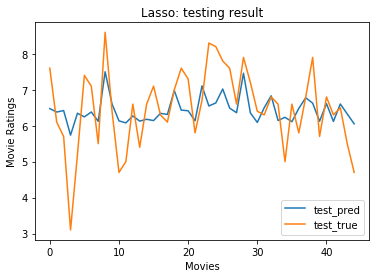

In [29]:
%matplotlib inline
plt.plot(list(range(len(y_test_pred))),y_test_pred, label='test_pred')
plt.plot(list(range(len(y_test))),y_test, label='test_true')
plt.title('Lasso: testing result')
plt.legend()
plt.xlabel('Movies')
plt.ylabel('Movie Ratings')

In [30]:
# Ridge regression
alpha_list = []
for i in range(10):
    alpha_list.append(2.0/(2**(i+1)))

val_mse_dic = {}
val_mse_list = []
train_mse_list = []
model_dic = {}

for alpha in alpha_list:
    
    model = Ridge(alpha=alpha, max_iter=1000)
    for i in range(10):
        X_train_tmp, X_val_tmp, y_train_tmp, y_val_tmp = train_test_split(X_train, y_train, test_size=0.2, random_state=1)
        model.fit(X_train_tmp, y_train_tmp)
        
        # training results
        y_train_pred = model.predict(X_train_tmp)
        train_mse = mean_squared_error(y_train_tmp, y_train_pred)
        train_mse_list.append(train_mse)
        
        # test model in validation set
        y_val_pred = model.predict(X_val_tmp)
        val_mse = mean_squared_error(y_val_tmp, y_val_pred)
        val_mse_list.append(val_mse)
        
    val_mse_dic[alpha]=avg(val_mse_list)
    model_dic[alpha]=model
    print 'alpha =', alpha, '\t avg val MSE =', avg(val_mse_list),'\t avg training MSE =', avg(train_mse_list)

alpha = 1.0 	 avg val MSE = 0.95855440368362 	 avg training MSE = 0.7236802647063926
alpha = 0.5 	 avg val MSE = 0.9640331968430498 	 avg training MSE = 0.7076475926767203
alpha = 0.25 	 avg val MSE = 0.9731786748718396 	 avg training MSE = 0.6950649795210107
alpha = 0.125 	 avg val MSE = 0.9843229782492353 	 avg training MSE = 0.6858756798317851
alpha = 0.0625 	 avg val MSE = 0.9957356545083401 	 avg training MSE = 0.6793611084262879
alpha = 0.03125 	 avg val MSE = 1.0062673553786599 	 avg training MSE = 0.6747099442605738
alpha = 0.015625 	 avg val MSE = 1.0154129024652565 	 avg training MSE = 0.6713006222366817
alpha = 0.0078125 	 avg val MSE = 1.0231046807067914 	 avg training MSE = 0.6687207623923622
alpha = 0.00390625 	 avg val MSE = 1.0294925626350206 	 avg training MSE = 0.6667085324356777
alpha = 0.001953125 	 avg val MSE = 1.0347945183747875 	 avg training MSE = 0.6650973917890933


In [31]:
# select model
alpha = min(val_mse_dic)
model = model_dic[alpha]

# test model
y_test_pred = model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)

print '(mean, std) of training error is',(avg(train_mse_list),np.std(train_mse_list))
print 'testing error is ', test_mse
print 'model score is ',model.score(X_test,y_test)

pd.DataFrame({'y_test_true': y_test, 'y_test_pred': y_test_pred, 'difference': y_test-y_test_pred}).head(10)


(mean, std) of training error is (0.6650973917890933, 0.02315425244458876)
testing error is  0.8054626985471043
model score is  0.31879000461171825


,difference,y_test_pred,y_test_true
0,1.125698,6.474302,7.6
1,-0.243844,6.343844,6.1
2,-0.737349,6.437349,5.7
3,-2.644480,5.744480,3.1
4,-1.176565,6.376565,5.2
5,1.155738,6.244262,7.4
6,0.689422,6.410578,7.1
7,-0.553076,6.053076,5.5
8,1.088408,7.511592,8.6
9,-0.193951,6.593951,6.4


Text(0,0.5,'Movie Ratings')

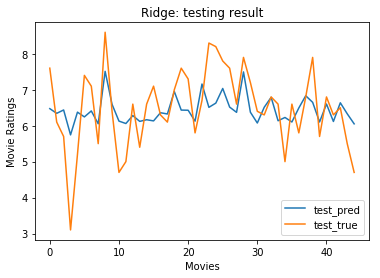

In [32]:
%matplotlib inline
plt.plot(list(range(len(y_test_pred))),y_test_pred, label='test_pred')
plt.plot(list(range(len(y_test))),y_test, label='test_true')
plt.title('Ridge: testing result')
plt.legend()
plt.xlabel('Movies')
plt.ylabel('Movie Ratings')